# Visualising field using `matplotlib`

There are two ways how a field can be visualised, using:
- `matplotlib`
- `k3d`

`matplotlib` provides two-dimensional plots of fields. This means that the field can be visualised only if was firstly intersected with a plane.

Let us say we have a sample, which is a nanocylinder of diametre $30\,\text{nm}$ and $50 \,\text{nm}$ height. The value of the field at $(x, y, z)$ point is $(-cy, cx, cz)$, with $c=10^{9}$. The norm of the field inside the cylinder is $10^{6}$.

Let us firstly build that field. We start by creating a rectangular mesh which can contain the cylinder we described.

In [1]:
import discretisedfield as df
%matplotlib inline

p1 = (-15e-6, -15e-6, -25e-6)
p2 = (15e-6, 15e-6, 25e-6)
cell = (1e-6, 1e-6, 1e-6)
mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

Please not that we activated inline plotting `%matplotlib inline` right after we imported `discretisedfield`. This is necessary if we want to draw plots in the Jupyter notebook.

Secondly, we want to define the norm. When we define the nanocylinder, the norm of the vector field outside the cylinder should be zero and outside $M_\text{s}$. The Python function is

In [2]:
def norm_fun(pos):
    x, y, z = pos
    if x**2 + y**2 < (15e-6)**2:
        return 1e6
    else:
        return 0

The Python function which defines the spatially varying field inside the cylinder is

In [3]:
def value_fun(pos):
    x, y, z = pos
    c = 1e6
    return (-c*y, c*x, c*z)

Now, we can create the field.

In [4]:
field = df.Field(mesh, dim=3, value=value_fun, norm=norm_fun)

## Plotting using `mpl`

The main function used to visualise the field using `matplotlib` is `discertisedfield.Field.mpl`. Let us try to run it.

In [5]:
try:
    field.mpl()
except ValueError:
    print('Exception raised.')

Exception raised.


The exception was raised because `matplotlib` plotting is available only for two-dimensional planes. Therefore, we have to first intersect the field with a plane and then plot it. Let us intersect it with $z=10$ plane and then call the `mpl` method.

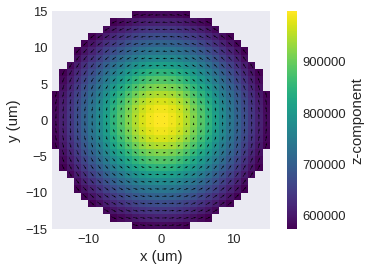

In [6]:
# NBVAL_IGNORE_OUTPUT
field.plane(z=10e-6).mpl()

The figure is probably too small to see the interesting features of the field we defined. Therefore, we can make it larger by passing `figsize` argument.

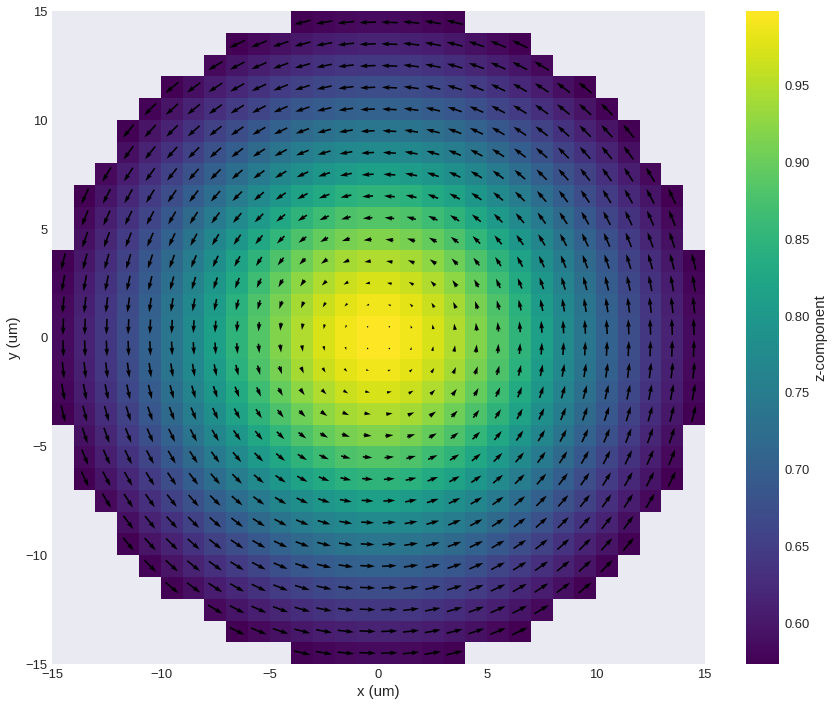

In [7]:
# NBVAL_IGNORE_OUTPUT
field.orientation.plane(z=10e-6).mpl(figsize=(15, 12))

Now, we can see that we plotted the $z$-plane intersection by looking at the $x$ and $y$ dimensions on the horizontal and vertical axes, respectively. Secondly, we see that there are two overlapped plots: a coloured plot (`imshow`) and a vector plot (`quiver`). `quiver` plot can only plot two-dimensional vector fields. More precisely, it plots the projection of a vector on the plane we intersected the field with. However, we then lose the information about the out-of-plane component of the vector field. Because of that, there is a scalar (`imshow`) field, together with a colorbar, whose colour depicts the $z$ component of the field. We can also notice, that all discretisation cells where the norm of the field is zero, are not plotted.

Similarly, we can plot a different plane

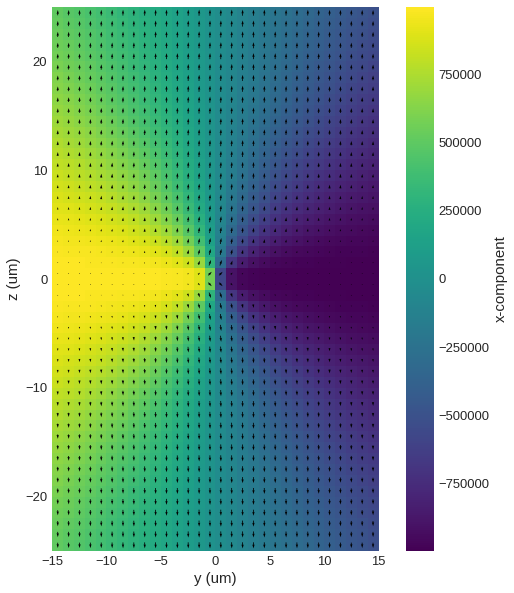

In [8]:
# NBVAL_IGNORE_OUTPUT
field.plane('x').mpl(figsize=(10, 10))

If there are too many discretisation cells on the plot, their number can decreased by passing `n` argument to the `plane` method.

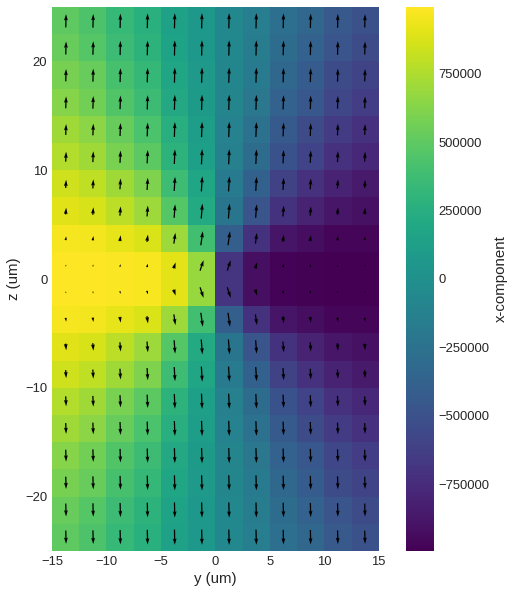

In [9]:
# NBVAL_IGNORE_OUTPUT
field.plane('x', n=(12, 20)).mpl(figsize=(10, 10))

## Building a custom plot

So far, we showed the default behaviour of the `discretisedfield.Field.mpl()`. However, it is often required that a custom plot is built. Here we show several ways how a custom plot can be built. There are three basic methods that can be used:
- `discretisedfield.Field.imshow()` for plotting scalar fields
- `discretisedfield.Field.quiver()` for plotting vector fields
- `discretisedfield.Field.colorbar()` for adding a colorbar

Let us start with some basic functionalities of `discretisedfield.Field.imshow()`. Subsequently, we will build a custom plotting function step-by-step. This way, we will show some basic functionality of different plotting methods and how they can be modified. Firstly, we have to create `matplotlib.axes.Axes object`.

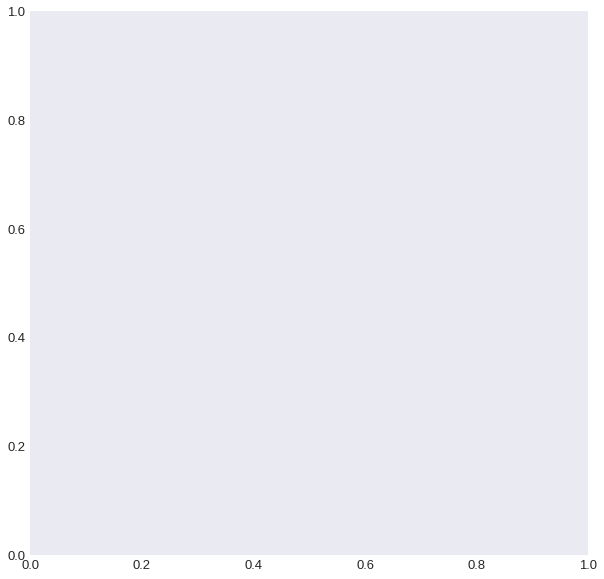

In [10]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt

def my_plot(field):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
my_plot(field)

After we created the axes object, we can now add the `imshow`. We need to pass the axes object we created.

Exception raised.


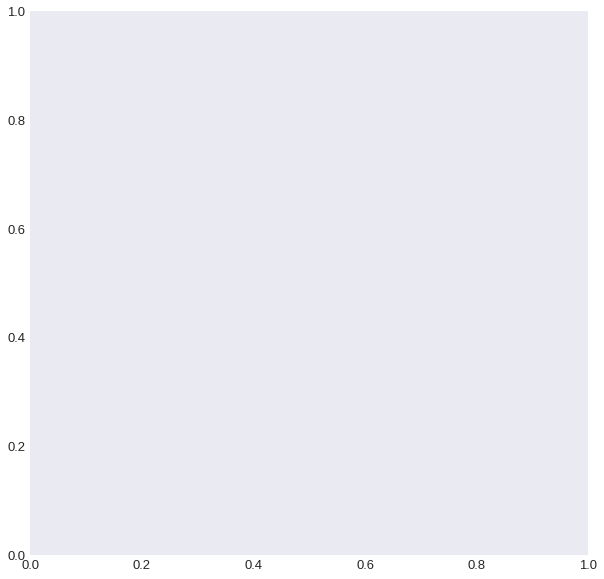

In [11]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    field.mpl.scalar(ax=ax)
    
try:
    my_plot(field)
except ValueError:
    print('Exception raised.')

An exception was raised because `discertisedfield.Field.imshow()` can only plot scalar fields. Therefore, we are going to extract the $z$ component of the field.

Exception raised.


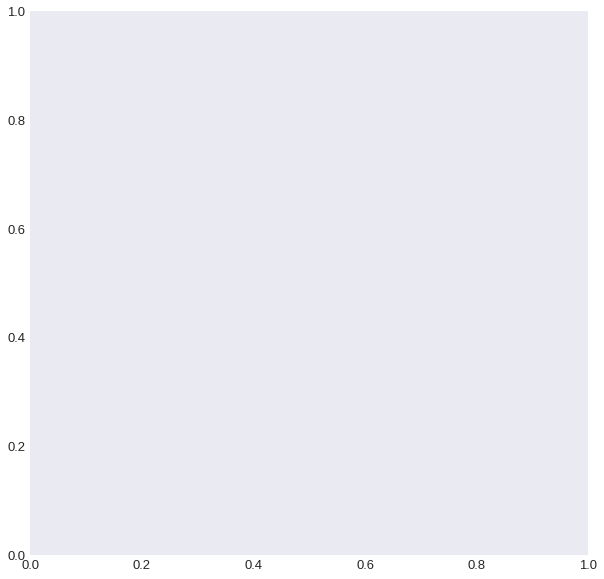

In [12]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    field.z.mpl.scalar(ax=ax)
    
try:
    my_plot(field)
except ValueError:
    print('Exception raised.')

This time, an exception was raised because only "sliced" fields can be plotted. We can slice the field using `discretisedfield.Field.plane()` function.

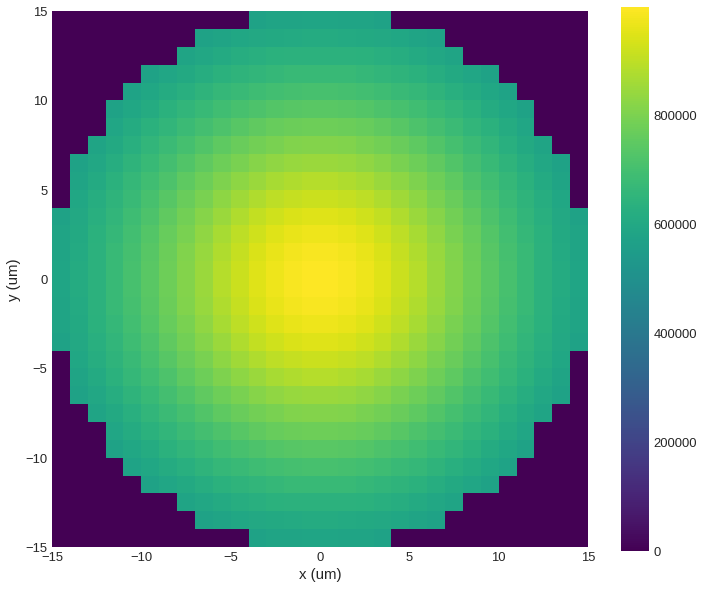

In [13]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax)
    
my_plot(field)

Now, we got a plot of the field's $z$ component. However, discretisation cells, which are outside the cylinder, are also plotted. This is because norm cannot be reconstructed from the scalar field passed to the `discretisedfield.Field.imshow()`. Therefore, we can pass the norm of the field as an argument.

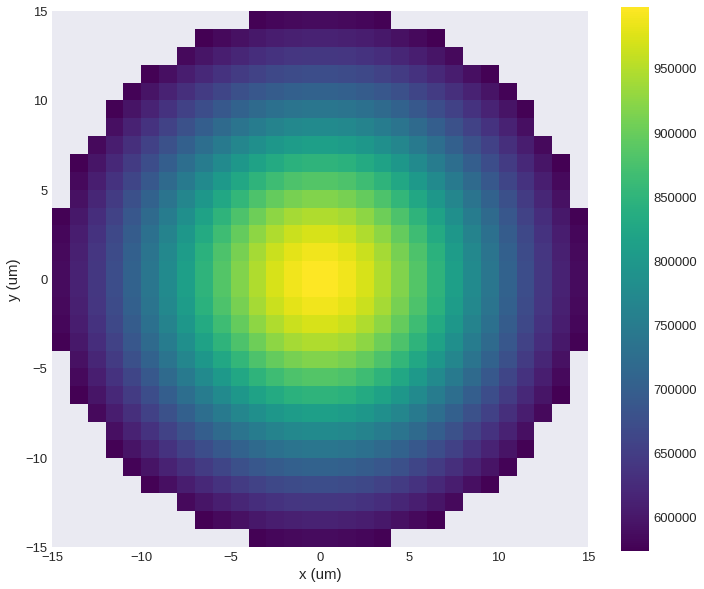

In [14]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm)
    
my_plot(field)

To modify this plot, we can pass any keyword argument that is accepted by the `matplotlib.pyplot.imshow` function. For its functionality, please refer to the [documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html). Let us, for example, change the colormap, by passing `cmap='plasma'`. The available colormaps are shown in the [matplotlib gallery](https://matplotlib.org/examples/color/colormaps_reference.html#color-example-code-colormaps-reference-py).

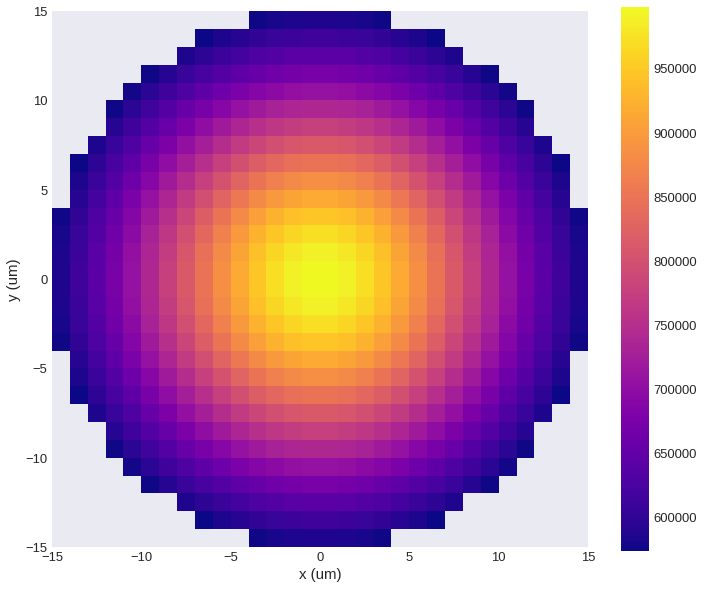

In [15]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    
my_plot(field)

In the next step, we can add the vector plot (`quiver`). Similar to `imshow`, we need to pass the axes object.

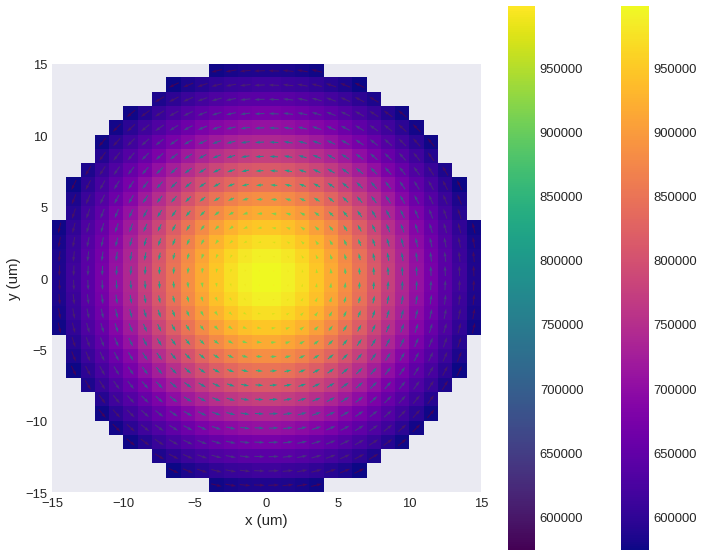

In [16]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    field.plane(z=10e-6).mpl.vector(ax=ax)   
    
my_plot(field)

We can now reduce the number of plotted vectors, by passing the `n` tuple to the `discretisedfield.Field.plane` function.

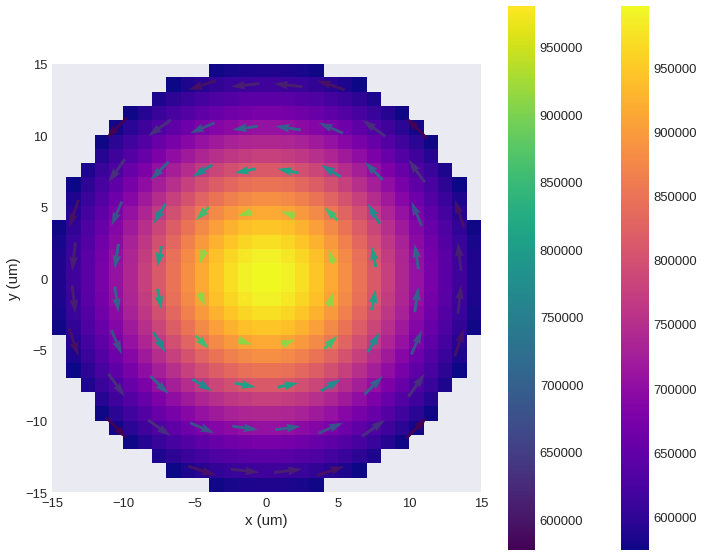

In [17]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    field.plane(z=10e-6, n=(10, 10)).mpl.vector(ax=ax)   
    
my_plot(field)

Please note that the vectors outside the cylinder were not plotted because their norm is zero and this was reconstructed from the vector field passed. All vectors plotted are black. They can be coloured by passing a scalar field according to which the vectors will be coloured. Let us colour them according to their $x$ component.

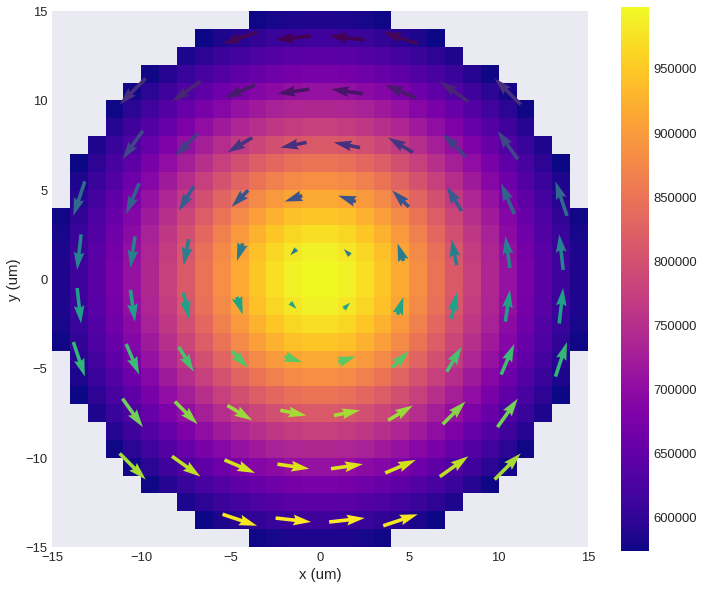

In [18]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    field.plane(z=10e-6, n=(10, 10)).mpl.vector(ax=ax, color_field=field.x, colorbar=False)   
    
my_plot(field)

Like previously, all keyword argument that can be accepted by `matplotlib.pyplot.quiver()` can be passed. For more information, please refer to its [documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html). As an example, let us change the width of arrow heads, by passing `headwidth` argument.

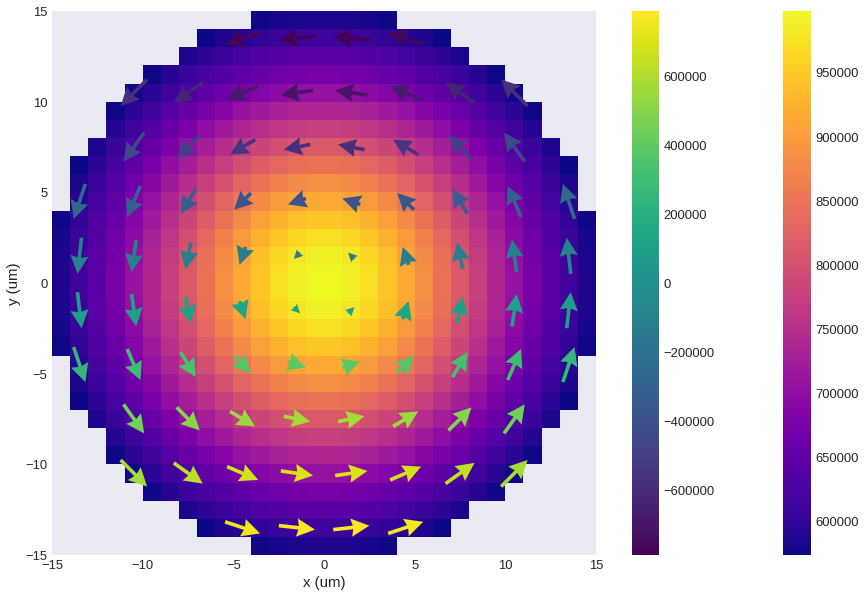

In [19]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    field.plane(z=10e-6, n=(10, 10)).mpl.vector(ax=ax, color_field=field.x, headwidth=5)   
    
my_plot(field)

Now, we can add a colorbar to the plot. For that, we need to pass `colorbar=True`.

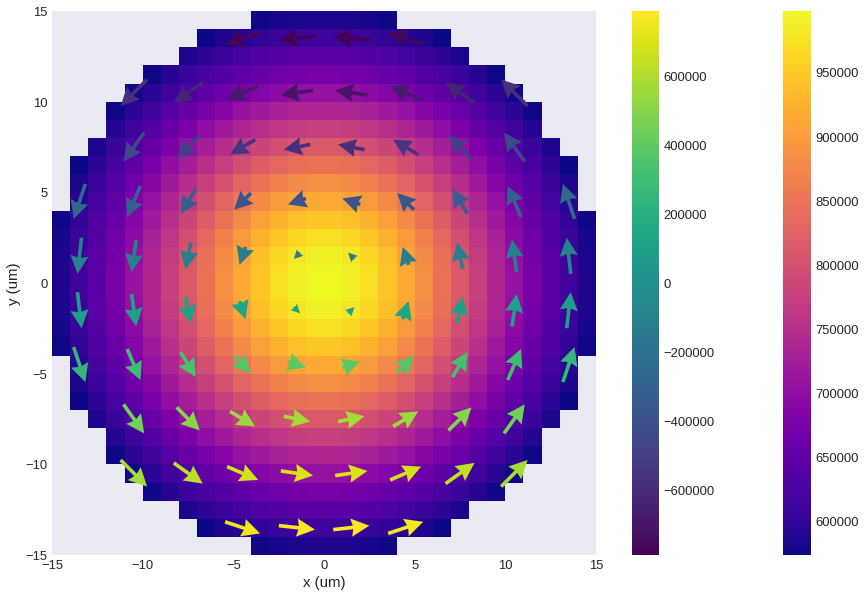

In [20]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma', colorbar=True)
    field.plane(z=10e-6, n=(10, 10)).mpl.vector(ax=ax, color_field=field.x, headwidth=5)  
    
my_plot(field)

Finally, we can add some annotations to the plot. All accepted modifications of axes can be found in [documentation](https://matplotlib.org/3.1.1/api/axes_api.html#the-axes-class).

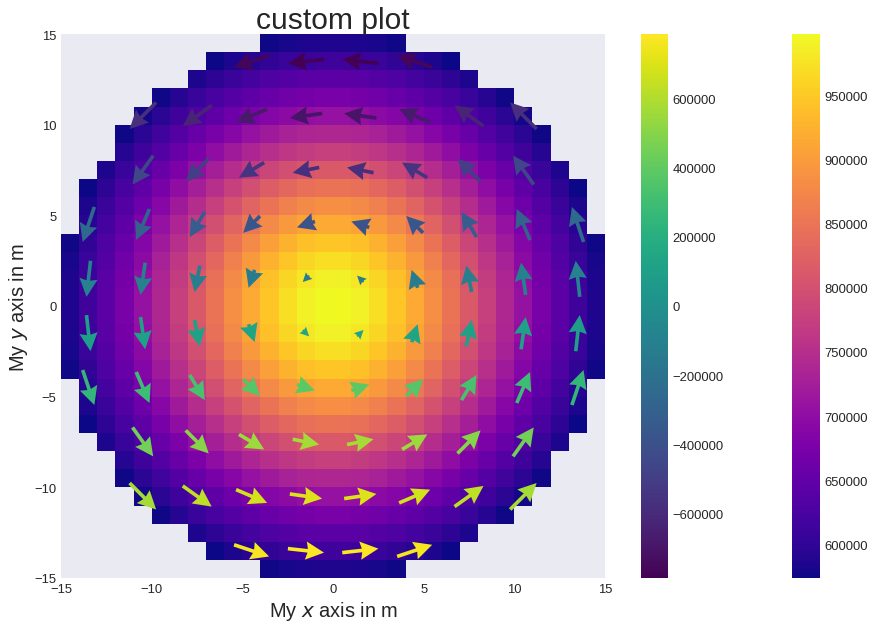

In [21]:
# NBVAL_IGNORE_OUTPUT
def my_plot(field):
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111)
    
    field.z.plane(z=10e-6).mpl.scalar(ax=ax, filter_field=field.norm, cmap='plasma')
    field.plane(z=10e-6, n=(10, 10)).mpl.vector(ax=ax, color_field=field.x, headwidth=5)  
    
    ax.set_xlabel(r'My $x$ axis in m', fontsize=20)
    ax.set_ylabel(r'My $y$ axis in m', fontsize=20)
    ax.set_title('custom plot', fontsize=30)
    
my_plot(field)

By modifying the steps we showed in this tutorial, numerous different plots can be obtained.

## Plotting field values along the line

Sometimes it is necessary to explore the field values along a certain line. More precisely, to plot the field values along a line defined between two points. Firstly, we need to obtain $z$ values of the field on a line between $(-15, 0, 0)$ and $(15, 0, 0)$ at $n=20$ points.

In [22]:
line = field.mesh.line(p1=(-15e-6, 0, 0), p2=(15e-6, 0, 0), n=20)
field_values = []
parameter = []
for point in line:
    x, y, z = point
    parameter.append(x)   # remember x-position for plot
    field_values.append(field(point))

# extract mx, my, mz as lists from lists of (mx, my, mz):
mx, my, mz = zip(*field_values)

Now, we can plot the field values along the line:

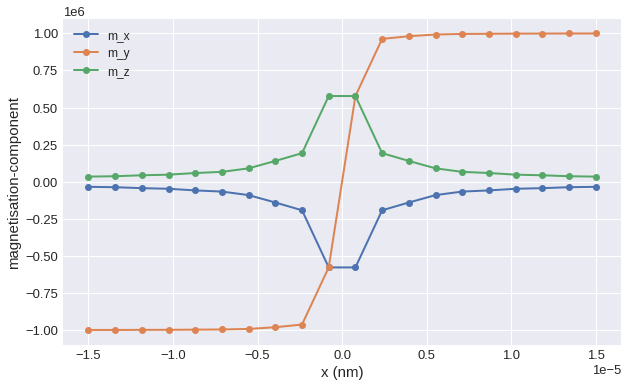

In [23]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(10, 6))
plt.plot(parameter, mx, 'o-', linewidth=2, label='m_x')
plt.plot(parameter, my, 'o-', linewidth=2, label='m_y')
plt.plot(parameter, mz, 'o-', linewidth=2, label='m_z')
plt.xlabel('x (nm)')
plt.ylabel('magnetisation-component')
plt.grid()
plt.legend()